In [1]:
%matplotlib inline
import argparse
import errno
import os
import numpy as np
from os.path import join
import scipy
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
from lmfit import Minimizer, Parameters
import pickle

import scipy.interpolate as interp

from ctisim import ITL_AMP_GEOM, E2V_AMP_GEOM
from ctisim.fitting import SimpleModel, SimulatedModel
from ctisim.utils import OverscanParameterResults
from ctisim import LinearTrap, SplineTrap
from ctisim.correction import trap_operator, electronics_operator

RAFT_NAMES = ['R01', 'R02', 'R03', 
              'R10', 'R13', 'R14',
              'R20', 'R23', 'R24',
              'R31', 'R32', 'R33', 'R34',
              'R41', 'R42', 'R43']

CCD_NAMES = ['S00', 'S01', 'S02',
             'S10', 'S11', 'S12',
             'S20', 'S21', 'S22']

directory = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R02/S02'
sensor_id = 'R02_S02'

## Electronics Fit

In [2]:
## Config variables
start = 3
stop = 13
ccd_type = 'itl'
max_signal = 150000.
error = 7.0/np.sqrt(2000.)

## Get existing overscan analysis results
hdulist = fits.open(join(directory, 
                         '{0}_overscan_results.fits'.format(sensor_id)))

cti_results = {i : 0.0 for i in range(1, 17)}
drift_scales = {i : 0.0 for i in range(1, 17)}
decay_times = {i : 0.0 for i in range(1, 17)}

## CCD geometry info
ncols = ITL_AMP_GEOM.nx + ITL_AMP_GEOM.prescan_width

for amp in range(1, 17):

    ## Signals
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]

    ## Data
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, 
                                            start:stop+1]

    params = Parameters()
    params.add('ctiexp', value=-6, min=-7, max=-5, vary=False)
    params.add('trapsize', value=0.0, min=0., max=10., vary=False)
    params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
    params.add('emissiontime', value=0.4, min=0.1, max=1.0, vary=False)
    params.add('driftscale', value=0.00022, min=0., max=0.001)
    params.add('decaytime', value=2.4, min=0.1, max=4.0)

    model = SimpleModel()

    minner = Minimizer(model.difference, params, 
                       fcn_args=(signals, data, error, ncols),
                       fcn_kws={'start' : start, 'stop' : stop})
    result = minner.minimize()

    if result.success:

        cti = 10**result.params['ctiexp']
        drift_scale = result.params['driftscale']
        decay_time = result.params['decaytime']
        cti_results[amp] = cti
        drift_scales[amp] = drift_scale.value
        decay_times[amp] = decay_time.value

param_results = OverscanParameterResults(sensor_id, 
                                         cti_results, 
                                         drift_scales, 
                                         decay_times)

## Low Signal Fitting

In [9]:
start = 1
stop = 2
max_signal = 10000.
error = 7.0/np.sqrt(2000.)
num_transfers = ITL_AMP_GEOM.nx + ITL_AMP_GEOM.prescan_width

cti_results = {amp : 0.0 for amp in range(1, 17)}
drift_scales = param_results.drift_scales
decay_times = param_results.decay_times

ncols = ITL_AMP_GEOM.nx + ITL_AMP_GEOM.prescan_width

for amp in range(1, 17):

    ## Signals
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]

    ## Data
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]
    
    ## CTI test
    lastpixel = signals
    overscan1 = data[:, 0]
    overscan2 = data[:, 1]
    test = (overscan1+overscan2)/(ncols*lastpixel)

    if np.median(test) > 8.E-6:
        print(amp)
    
        params = Parameters()
        params.add('ctiexp', value=-6, min=-7, max=np.log10(5E-6), vary=True)
        params.add('trapsize', value=5.0, min=0., max=30., vary=True)
        params.add('scaling', value=0.08, min=0, max=1.0, vary=True)
        params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=True)
        params.add('driftscale', value=drift_scales[amp], min=0., max=0.001, vary=False)
        params.add('decaytime', value=decay_times[amp], min=0.1, max=4.0, vary=False)

        model = SimulatedModel()
        minner = Minimizer(model.difference, params, fcn_args=(signals, data, error, num_transfers, ITL_AMP_GEOM),
                           fcn_kws={'start' : start, 'stop' : stop, 'trap_type' : 'linear'})
        result = minner.minimize()

    else:
    
        params = Parameters()
        params.add('ctiexp', value=-6, min=-7, max=np.log10(5E-6), vary=True)
        params.add('trapsize', value=0.0, min=0., max=10., vary=False)
        params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
        params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=False)
        params.add('driftscale', value=drift_scales[amp], min=0., max=0.001, vary=False)
        params.add('decaytime', value=decay_times[amp], min=0.1, max=4.0, vary=False)

        model = SimulatedModel()
        minner = Minimizer(model.difference, params, fcn_args=(signals, data, error, num_transfers, ITL_AMP_GEOM),
                           fcn_kws={'start' : start, 'stop' : stop, 'trap_type' : 'linear'})
        result = minner.minimize()
        
    cti_results[amp] = 10**result.params['ctiexp'].value

param_results.cti_results = cti_results
print(param_results.cti_results)
outfile = '{0}_parameter_results_test.fits'.format(sensor_id)
param_results.write_fits(outfile, overwrite=True)

8
9
{1: 4.782903059936636e-07, 2: 6.329076972190089e-07, 3: 1.0901289324597583e-06, 4: 7.722133931028492e-07, 5: 7.109255223846054e-07, 6: 5.848165607752086e-07, 7: 3.7934814956407077e-07, 8: 4.894211523151182e-06, 9: 5.122726454462956e-07, 10: 6.065713009801495e-07, 11: 7.649513734550127e-07, 12: 6.382880612276435e-07, 13: 7.292096174189216e-07, 14: 7.140729873548113e-07, 15: 6.378176670062388e-07, 16: 4.5771701504584997e-07}


{1: 4.782903059936636e-07, 2: 6.329076972190089e-07, 3: 1.0901289324597583e-06, 4: 7.722133931028492e-07, 5: 7.109255223846054e-07, 6: 5.848165607752086e-07, 7: 3.7934814956407077e-07, 8: 4.894211523151182e-06, 9: 5.122726454462956e-07, 10: 6.065713009801495e-07, 11: 7.649513734550127e-07, 12: 6.382880612276435e-07, 13: 7.292096174189216e-07, 14: 7.140729873548113e-07, 15: 6.378176670062388e-07, 16: 4.5771701504584997e-07}

## Make Traps

In [4]:
spltraps = {}
max_signal = 150000.

for amp in range(1, 17):

    ## Signals
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]

    ## Data
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

    ## Second model: model with electronics
    params = Parameters()
    params.add('ctiexp', value=np.log10(param_results.cti_results[amp]), min=-7, max=-5, vary=False)
    params.add('trapsize', value=0.0, min=0., max=10., vary=False)
    params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
    params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=False)
    params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
    params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
    model = SimpleModel.model_results(params,signals, num_transfers, start=start, stop=stop)

    res = np.sum((data-model)[:, :3], axis=1)
    new_signals = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, 0]
    rescale = param_results.drift_scales[amp]*new_signals
    new_signals = np.asarray(new_signals - rescale, dtype=np.float64)
    x = new_signals
    y = np.maximum(0, res)

    # Pad left with ramp
    y = np.pad(y, (10, 0), 'linear_ramp', end_values=(0, 0))
    x = np.pad(x, (10, 0), 'linear_ramp', end_values=(0, 0))

    # Pad right with constant
    y = np.pad(y, (1, 1), 'constant', constant_values=(0, y[-1]))
    x = np.pad(x, (1, 1), 'constant', constant_values=(-1, 200000.))

    f = interp.interp1d(x, y)
    spltrap = SplineTrap(f, 0.4, 1)
    pickle.dump(spltrap, open('{0}_amp{1}_traps.pkl'.format(sensor_id, amp), 'wb'))

## Checking Fit

In [5]:
## Make ramp image from data
max_signal = 150000.
amp = 16
ncols = ITL_AMP_GEOM.nx+ITL_AMP_GEOM.prescan_width

all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, :]

imarr = np.zeros((data.shape[0], ncols+data.shape[1]))
ramp = np.tile(signals, (ITL_AMP_GEOM.nx, 1)).T
imarr[:, ITL_AMP_GEOM.prescan_width:ncols] = ramp
imarr[:, ncols:] = data

In [6]:
## See what electronics correction does
param_results = OverscanParameterResults.from_fits('{0}_parameter_results.fits'.format(sensor_id))
E = electronics_operator(imarr, param_results.drift_scales[amp],
                         param_results.decay_times[amp],
                         num_previous_pixels=15)

corrected_electronics = imarr-E

## See what trap correction does
cti = param_results.cti_results[amp]
trap = pickle.load(open('{0}_amp{1}_traps.pkl'.format(sensor_id, amp), 'rb'))
T = trap_operator(imarr, trap)
corrected = corrected_electronics-(1-cti)*T

Text(0, 0.5, 'Serial CTI')

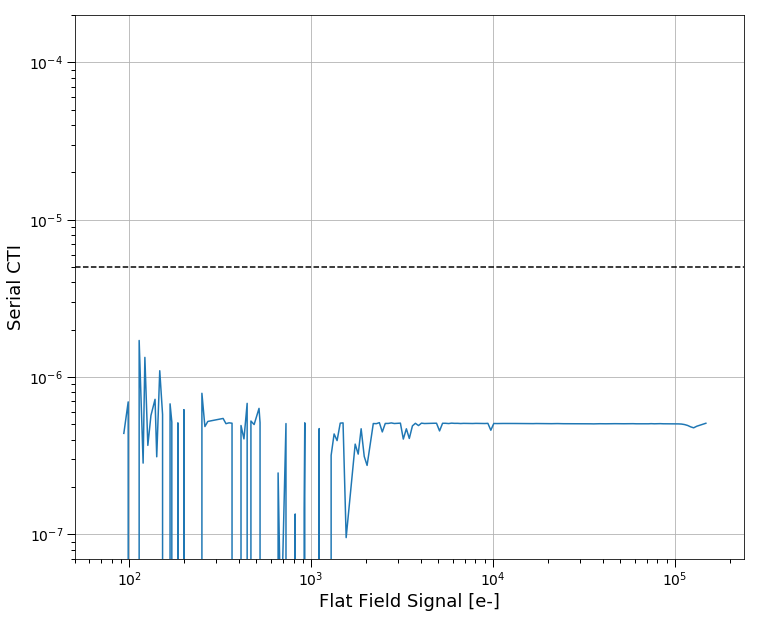

In [7]:
oscan1 = corrected[:, 513]
oscan2 = corrected[:, 514]
lastpix = corrected[:, 512]
cti_results = (oscan1+oscan2)/(lastpix*ncols)

new_signals = np.mean(corrected[:, 50:450], axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(new_signals, cti_results)
ax.axhline(y=5.E-6, linestyle='--', color='black')

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='both', which='major', length=8, width=1)
ax.tick_params(axis='both', which='minor', length=4, width=1)
ax.set_ylim(bottom=7E-8, top=2E-4)
ax.set_xlim(left=50.0, right=240000.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', axis='both')
ax.set_xlabel('Flat Field Signal [e-]', fontsize=18)
ax.set_ylabel('Serial CTI', fontsize=18)

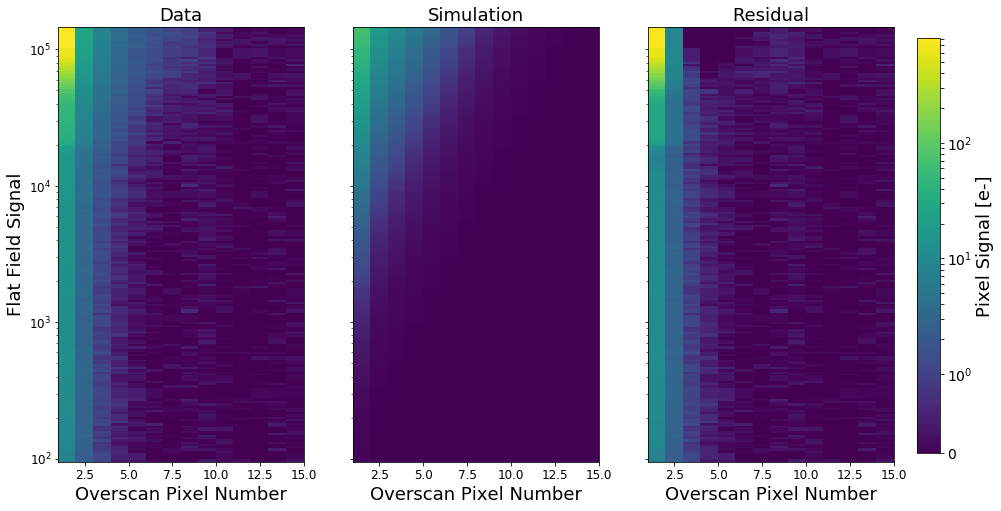

In [11]:
param_results = OverscanParameterResults.from_fits(outfile)

max_signal = 150000.
error = 7.2/np.sqrt(2000.)

start = 1
stop = 15
num_transfers = 512

amp = 9

## Signals
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]

## Data
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

## Model
params = Parameters()
params.add('cti', value=param_results.cti_results[amp], vary=False)
params.add('trapsize', value=0.0, min=0., max=10., vary=False)
params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=False)
params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
model = SimulatedModel.model_results(params,signals, num_transfers, start=start, stop=stop, 
                                     amp_geom=ITL_AMP_GEOM, trap_type=None)

## Setting up PColor plot
vmin = 0.0
vmax = np.max(data)
y=signals
x=np.arange(start, stop+1)
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
im0 = axes[0].pcolor(X, Y, data, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im1 = axes[1].pcolor(X, Y, model, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im2 = axes[2].pcolor(X, Y, data-model,
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
axes[0].set_yscale('log')
axes[0].set_ylabel('Flat Field Signal', fontsize=18)
axes[0].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_title('Data', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[1].set_title('Simulation', fontsize=18)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[2].set_title('Residual', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Pixel Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14)